### Ana Carolina Junger
Atividade 2 INF2137

## 1. Definição do Problema

O Dataset utilizado neste projeto é o Fake.Br Corpus, o primeiro corpus de fake news em português [Monteiro et al., 2018]. As informações foram extraídas do seu projeto no github (https://github.com/roneysco/Fake.br-Corpus). Nele, temos 3 versões do corpus: a primeira com os textos por completo + seus metadados, a segunda com os textos já pre processados pelos autores e a terceira com os pares de fake e true news truncados para terem o mesmo tamanho. Nessa segunda parte do projeto, iremos avaliar os dados pré processados.

A user story deste problema é a mesma da primeira versão

# 2. Iniciando o notebook + imports

In [50]:
%load_ext autoreload
%autoreload 2
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.ensemble import VotingClassifier
import pickle

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from grid_search import GridSearchProcess
from view_model_results import ViewModelsResults

import warnings
warnings.filterwarnings("ignore")

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# 3. Carregando o Dataset

Esse arquivo já está pre-processado, normalizando as palavras, removendo stopwords, acentos etc

In [4]:
url = "https://raw.githubusercontent.com/roneysco/Fake.br-Corpus/master/preprocessed/pre-processed.csv"

df_orig = pd.read_csv(url, skiprows=0, delimiter=',', usecols=["label", "preprocessed_news"])

In [5]:
df = df_orig.copy()

In [18]:
vectorizer = CountVectorizer()
X_processed = vectorizer.fit_transform(df["preprocessed_news"])

tfidfconverter = TfidfVectorizer()
X_processed_Tfid = tfidfconverter.fit_transform(df["preprocessed_news"])

len(vectorizer.get_feature_names_out())

79541

Como nesse caso estamos rodando o modelo considerando apenas bag of words e TFID, não é necessário fazer o pré processamento dos dados

## 4. Modelos de Classificação

Já é sabido pelo modelo que o SVM performa muito bem com o bag-of-words [Monteiro et al., 2018], dessa forma iremos avaliar o variações do bag-of-words em diferentes modelos. De maneira analoga, também iremos avaliar o TFIDF.

### Analisando os melhores parametros para cada modelo

In [6]:
# variações 

# definindo o corte e a semente 
test_size = 0.20
seed = 7
# Parâmetros e partições da validação cruzada
scoring = 'accuracy'
num_particoes = 10

kfold = StratifiedKFold(n_splits=num_particoes, shuffle=True, random_state=seed)

max_features = [1000, 5000, 10000] # maximo que roda

In [12]:
results = []
for max_feature in max_features:
  bag_of_words = CountVectorizer(max_features=max_feature)
  X_processed = bag_of_words.fit_transform(df["preprocessed_news"])
  
  X_train, X_test, y_train, y_test = train_test_split(X_processed.toarray(), df["label"], test_size=test_size, random_state=seed)
  print("BAG-OF-WORDS MAX-FEATURE: ", max_feature)
  result = GridSearchProcess().run(X_train=X_train, y_train=y_train, scoring=scoring, kfold=kfold)
  results.append(("BOW", max_feature, result))
  
  tfidfconverter = TfidfVectorizer(max_features=max_feature)
  X_processed_Tfid = tfidfconverter.fit_transform(df["preprocessed_news"])
  X_train, X_test, y_train, y_test = train_test_split(X_processed_Tfid.toarray(), df["label"], test_size=test_size, random_state=seed)
  print("TFIDF MAX-FEATURE: ", max_feature)
  result = GridSearchProcess().run(X_train=X_train, y_train=y_train, scoring=scoring, kfold=kfold)
  results.append(("TFIDF", max_feature, result))
  

BAG-OF-WORDS MAX-FEATURE:  1000
Melhor KNN : 0.807639 usando {'metric': 'euclidean', 'n_neighbors': 1}
Melhor Decision Tree : 0.907813 usando {'criterion': 'entropy', 'max_depth': 12}
Melhor Navie Bayes : 0.947917 usando {'var_smoothing': 1.8329807108324375e-05}
Melhor SVM : 0.961806 usando {'C': 2.0, 'kernel': 'rbf'}
TFIDF MAX-FEATURE:  1000
Melhor KNN : 0.734375 usando {'metric': 'euclidean', 'n_neighbors': 1}
Melhor Decision Tree : 0.902431 usando {'criterion': 'gini', 'max_depth': 7}
Melhor Navie Bayes : 0.839410 usando {'var_smoothing': 0.012742749857031341}
Melhor SVM : 0.958681 usando {'C': 2.0, 'kernel': 'rbf'}
BAG-OF-WORDS MAX-FEATURE:  5000
Melhor KNN : 0.760938 usando {'metric': 'euclidean', 'n_neighbors': 1}
Melhor Decision Tree : 0.910590 usando {'criterion': 'entropy', 'max_depth': 15}
Melhor Navie Bayes : 0.942187 usando {'var_smoothing': 1.8329807108324375e-05}
Melhor SVM : 0.962847 usando {'C': 1.7, 'kernel': 'rbf'}
TFIDF MAX-FEATURE:  5000
Melhor KNN : 0.726910 usando

O Algoritimo rodou até 10000 features, por aproximadamente 12 horas, depois travou o computador, vamos considerar esse o valor máximo possível de manipular

### Criação e avaliação dos modelos

In [51]:
def get_params_by_max_feature_and_method(results, method, max_feature):
  result = filter(lambda x: x[0] == method and x[1] == max_feature, results)
  return list(result)[0][2]

In [19]:
results_models = []
for max_feature in max_features:
  bag_of_words = CountVectorizer(max_features=max_feature)
  X_processed = bag_of_words.fit_transform(df["preprocessed_news"])
  
  X_train, X_test, y_train, y_test = train_test_split(X_processed.toarray(), df["label"], test_size=test_size, random_state=seed)
  print("BAG-OF-WORDS MAX-FEATURE: ", max_feature)
  models_results, names = ViewModelsResults().run(best_params_list=get_params_by_max_feature_and_method(results, "BOW", max_feature), 
                                                X_train=X_train,
                                                y_train=y_train,
                                                scoring=scoring, 
                                                kfold=kfold, 
                                                tag=f"BAG-OF-WORDS-{max_feature}-max-features")
  # result = GridSearchProcess().run(X_train=X_train, y_train=y_train, scoring=scoring, kfold=kfold)
  results_models.append((f"BAG-OF-WORDS-{max_feature}-max-features", models_results, names))
  
  tfidfconverter = TfidfVectorizer(max_features=max_feature)
  X_processed_Tfid = tfidfconverter.fit_transform(df["preprocessed_news"])
  X_train, X_test, y_train, y_test = train_test_split(X_processed_Tfid.toarray(), df["label"], test_size=test_size, random_state=seed)
  print("TFIDF MAX-FEATURE: ", max_feature)
  models_results, names = ViewModelsResults().run(best_params_list=get_params_by_max_feature_and_method(results, "TFIDF", max_feature), 
                                                X_train=X_train,
                                                y_train=y_train,
                                                scoring=scoring, 
                                                kfold=kfold, 
                                                tag=f"TFIDF-{max_feature}-max-features")
  results_models.append((f"TFIDF-{max_feature}-max-features", models_results, names))

BAG-OF-WORDS MAX-FEATURE:  1000
LR-BAG-OF-WORDS-1000-max-features: 0.954 (0.010)
KNN-BAG-OF-WORDS-1000-max-features: 0.808 (0.013)
Decision Tree-BAG-OF-WORDS-1000-max-features: 0.904 (0.009)
Navie Bayes-BAG-OF-WORDS-1000-max-features: 0.948 (0.007)
SVM-BAG-OF-WORDS-1000-max-features: 0.962 (0.007)
Bag-BAG-OF-WORDS-1000-max-features: 0.940 (0.011)
RF-BAG-OF-WORDS-1000-max-features: 0.945 (0.011)
ET-BAG-OF-WORDS-1000-max-features: 0.943 (0.010)
Ada-BAG-OF-WORDS-1000-max-features: 0.953 (0.008)
GB-BAG-OF-WORDS-1000-max-features: 0.954 (0.010)
Vot-BAG-OF-WORDS-1000-max-features: 0.961 (0.009)
TFIDF MAX-FEATURE:  1000
LR-TFIDF-1000-max-features: 0.950 (0.007)
KNN-TFIDF-1000-max-features: 0.734 (0.018)
Decision Tree-TFIDF-1000-max-features: 0.899 (0.012)
Navie Bayes-TFIDF-1000-max-features: 0.839 (0.009)
SVM-TFIDF-1000-max-features: 0.959 (0.007)
Bag-TFIDF-1000-max-features: 0.926 (0.007)
RF-TFIDF-1000-max-features: 0.946 (0.008)
ET-TFIDF-1000-max-features: 0.949 (0.012)
Ada-TFIDF-1000-max-f

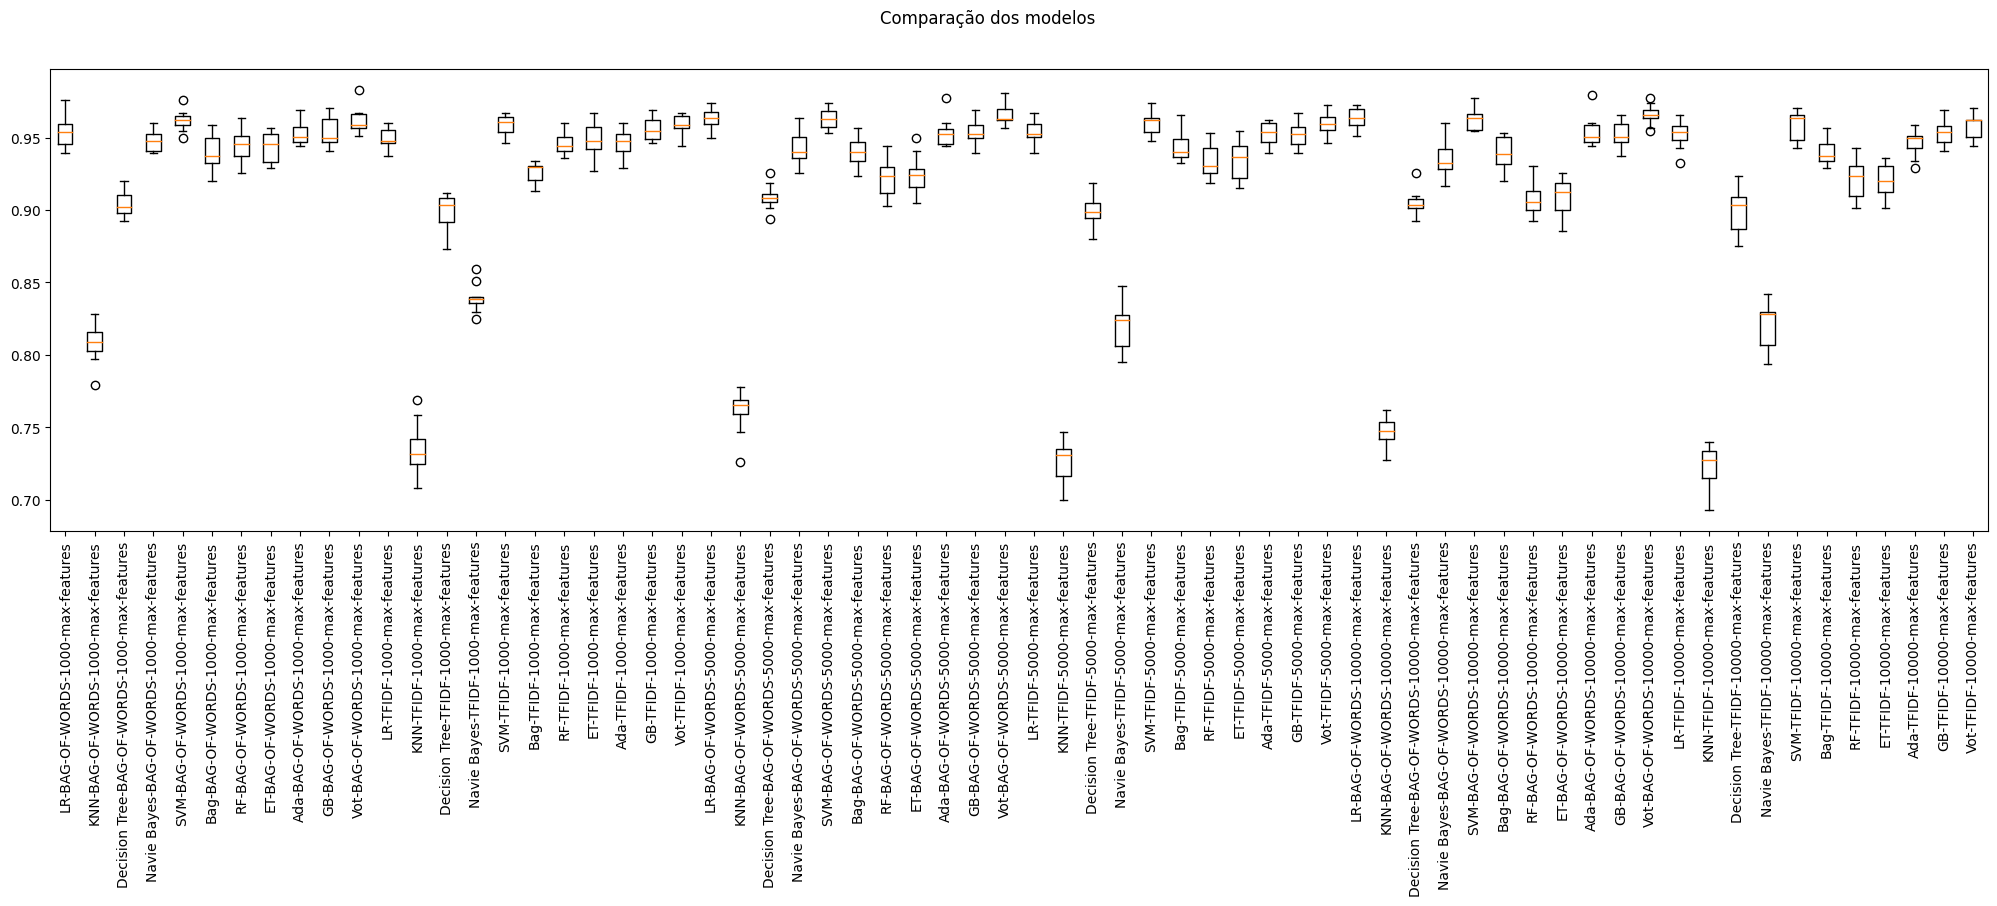

In [29]:
results_models_aux = results_models.copy()
results_models_aux

results_final = []
names = []

for result_model in results_models_aux:
  results_final.extend(result_model[1])
  names.extend(result_model[2])
  
  
# Comparação dos modelos
fig = plt.figure(figsize=(25,6))
fig.suptitle('Comparação dos modelos') 
ax = fig.add_subplot(111) 
plt.boxplot(results_final) 
ax.set_xticklabels(names, rotation=90)
plt.show()


A partir do gráfico percebemos que o KNN performa mal para todos os cenários, o que faz sentido visto que estes tratamentos geram uma base de dados esparsa. Também temos o Decision Tree perfomando abaixo para todas as versões e o Naive Bayes para os TFIDF. E dos melhores, temos que o Voting Classifier perfomou bem e todos os cenários, que para o Bag Of Words com 5000 ou 10000 max features performou com uma acurária de 0.966, a melhor média.

No caso do Bag Of Words tivemos uma melhora com o aumento do max feature para alguns modelos, como Voting Classifier. Mas, algumas pioras como Random Forrest. Num geral, os modelos emsambles se saíram melhores do que os modelos puros

O melhor resultado foi para o Bag-of-words com 5000 ou 10000 max features com o modelo Voting Classifier e acurácia de 0.966

## 5. Finalização do modelo

In [46]:
# Preparação do modelo
bag_of_words = CountVectorizer(max_features=5000)
X_processed = bag_of_words.fit_transform(df["preprocessed_news"])

X_train, X_test, y_train, y_test = train_test_split(X_processed.toarray(), df["label"], test_size=test_size, random_state=seed)

best_params = get_params_by_max_feature_and_method(results, "BOW", 5000)
view_models_results = ViewModelsResults()
best_decision_tree = view_models_results.get_best_params("Decision Tree", best_params)
best_svm = view_models_results.get_best_params("SVM", best_params)


bases = []
model1 = LogisticRegression(max_iter=200)
bases.append(('logistic', model1))
model2 = DecisionTreeClassifier(**best_decision_tree)
bases.append(('cart', model2))
model3 = SVC(**best_svm)
bases.append(('svm', model3))

model = VotingClassifier(bases)
model.fit(X_train, y_train)

VotingClassifier(estimators=[('logistic', LogisticRegression(max_iter=200)),
                             ('cart',
                              DecisionTreeClassifier(criterion='entropy',
                                                     max_depth=15)),
                             ('svm', SVC(C=1.7))])

In [48]:
artifact_pkl_filename = 'model_text.pkl'

local_path = artifact_pkl_filename
with open(local_path, 'wb') as model_file:
  pickle.dump(model, model_file)

In [49]:
loaded_pkl_model = pickle.load(open(artifact_pkl_filename, 'rb'))

pkl_results = loaded_pkl_model.score(X_test, y_test)
print('Pickle: ', pkl_results)
# Estimativa da acurácia no conjunto de teste
predictions = loaded_pkl_model.predict(X_test)
print(accuracy_score(y_test, predictions))
print(confusion_matrix(y_test, predictions))
print(classification_report(y_test, predictions))

Pickle:  0.9618055555555556
0.9618055555555556
[[722  21]
 [ 34 663]]
              precision    recall  f1-score   support

        fake       0.96      0.97      0.96       743
        true       0.97      0.95      0.96       697

    accuracy                           0.96      1440
   macro avg       0.96      0.96      0.96      1440
weighted avg       0.96      0.96      0.96      1440



## 6. Implantando o modelo

Da mesma forma da versão 1, implantaremos o modelo de forma Serveless, na Azure Functions. O modelo funcionará com previsões online, onde o cliente passa a url da noticia e o modelo avalia se é falsa ou não, de forma síncrona. Para isso é necessário criar uma pequena aplicação frontend para que o usuário posso inserir o link da notícia. Idealmente, faziamos um retreinamento deste modelo com notícias mais atuais, visto que o modelo de escrita pode variar ao longo dos anos, mas isso é muito custoso, pois é um trabalho manual.

Para um trabalho futuro é interessante avaliar outras representações de NLP e também explorar outros atributos do bag of words, pois como tivemos uma acurácia bem alto, os dados podem estar com algum viés.